<a href="https://colab.research.google.com/github/AndresSebad/benchmark-vector-bbdd/blob/main/benchmark/elastic/ElasticSearch_Test0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

!pip install elasticsearch==8.11
!pip install docker
#!apt install default-jdk > /dev/null


[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 147.6/147.6 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 9.3/9.3 MB 4.5 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip


In [226]:
try:
    import os
    import elasticsearch
    from elasticsearch import Elasticsearch
    import numpy as np
    import pandas as pd
    import sys
    import json
    from ast import literal_eval
    from tqdm import tqdm
    import datetime
    from elasticsearch import helpers
    import threading
    from matplotlib import pyplot as plt
    import datetime
    from dateutil import parser

except Exception as e:
    print(f"error: {e}")

In [267]:
class DatabaseBenchmark:
    def __init__(self, es):
        self.es = es

    def query(self, embedded_vector, n_results, index = "vector-index"):
        # Squared L2
        #results = self.db_collection.query(
        #    query_texts=embedded_vector, # Lista de strings
        #    n_results=n_results # Número de resultados
        #)
        #query = self.es.search(
        #    index=index,
        #    body={
        #    "size":n_results,
        #    "query": {
        #        "match":{
        #            "embedding": embedded_vector
        #        }
        #    }
        #    }
        #)

        query_vector = {
                    "field": "embedding",
                    "query_vector": embedded_vector,
                    "k": n_results,
                    "num_candidates": n_results
                }

        # run the query
        result = self.es.search(index="vector-index", knn=query_vector)

        output = pd.json_normalize((result['hits']['hits']))
        pass


    def create_index(self, index_name):
        mapping = {
            "mappings": {
                    "properties": {
                        "AUTOR": {
                            "type": "text"
                        },
                        "TITULO": {
                            "type": "text"
                        },
                        "embedding": {
                            "type": "dense_vector",
                            "dims": 64
                        }
                    }
                }

            }

        response = self.es.indices.create(
            index=index_name,
            body=mapping,
            ignore=400 # ignore 400 already exists code
        )
        return response

    def build_index(self, documents):
        #self.db_collection.add(
        #    documents=documents, # Lista Documentos
        #    metadatas=metadatas, # Lista de Diccionarios
        #    ids=ids # Lista de Ids
        #)
        try:

            for index, row in data.iterrows():
                #print(row["AUTOR"]," -- ", row["TITULO"], " ||||", row["embedding"])
                doc = {"AUTOR": row["AUTOR"], "TITULO": row["TITULO"], "embedding": row["embedding"]}
                es.index(index="vector-index", body=doc)

            #res = helpers.bulk(self.es, documents)
            #print("successfully imported to elasticsearch.")
        except Exception as e:
            print(f"error: {e}")
        pass

    def measure_qps(self, temp_vector, num_queries=1000):
        import timeit

        start_time = timeit.default_timer()
        for _ in range(num_queries):
            self.query(temp_vector, n_results=1)
        end_time = timeit.default_timer()

        qps = num_queries / (end_time - start_time)

        return qps

    def measure_latency(self, temp_vector):
        import timeit

        start_time = timeit.default_timer()
        self.query(temp_vector, 1)
        latency = timeit.default_timer() - start_time

        return latency

    def measure_index_building_time(self, documents):
        import timeit

        start_time = timeit.default_timer()
        self.build_index(documents)
        index_building_time = timeit.default_timer() - start_time

        return index_building_time

    def remove_index(self, index_name):
        self.es.options(ignore_status=[400,404]).indices.delete(index=index_name)


In [228]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import numpy as np

def vectorize_embed(data: pd.DataFrame, datacol:str = 'TEXTO', dim = 64) -> np.array:

    vectorizer = TfidfVectorizer()
    emb = vectorizer.fit_transform(data['TEXTO'])
    svd = TruncatedSVD(dim)
    embedding = svd.fit_transform(emb)

    return vectorizer, svd, embedding

def gen_dataset(dataurl: str = 'textos.csv', datacol:str = 'TEXTO', dim = 64) ->pd.DataFrame:
    data = pd.read_csv(dataurl)
    vectorizer, svd, embedding = vectorize_embed(data, datacol, dim)
    data = data.drop(columns = datacol).reset_index(drop = True)
    data['embedding'] = [vec.tolist() for vec in embedding]
    return vectorizer, svd, data

In [229]:
def profiler(container):
    cpu_max = 0
    container_history = [] # create an empty list to store the stats
    std_array = np.zeros([50])
    std_index = 0
    for stats in container.stats(stream=True, decode=True): # iterate over the stats generator
        container_history.append(stats)
        cpu_value = stats["cpu_stats"]["cpu_usage"]["total_usage"]
        memory_value = stats["memory_stats"]["usage"]
        std_array[std_index] = cpu_value
        std_index = std_index + 1
        if std_index>=50:
            std_index = 0
        #print(std_array.std())
        if cpu_value > cpu_max:
            cpu_max = cpu_value
        if std_array.std() < 0.1*cpu_max:
            break
    return container_history

In [230]:
def cpu_usage_plot(stats_history, caption, return_percentages = False):
    cpu_total_usage = []

    wait_index = 0
    for stats in stats_history:
        if wait_index > 1:
            UsageDelta = stats['cpu_stats']['cpu_usage']['total_usage'] - stats['precpu_stats']['cpu_usage']['total_usage']
            SystemDelta = stats['cpu_stats']['system_cpu_usage'] - stats["precpu_stats"]["system_cpu_usage"]
            len_cpu = len(stats['cpu_stats']['cpu_usage']['percpu_usage'])
            percentage = (UsageDelta / SystemDelta) * len_cpu * 100
            cpu_total_usage.append(percentage)
        wait_index = wait_index + 1

    time = [stats["read"] for stats in stats_history]
    time = [parser.parse(t) for t in time]
    time_diff = [(t - time[0]).total_seconds() for t in time]
    delta = len(time_diff)-len(cpu_total_usage)
    plt.plot(time_diff[delta:], cpu_total_usage)
    plt.xlabel("Time [s]")
    plt.ylabel("CPU Percent Usage")
    plt.title("CPU usage for " + caption)
    plt.grid()
    plt.show()
    if return_percentages:
        return cpu_total_usage

In [231]:
def memory_usage_plot(stats_history, caption, return_memory = False):
    memory_total_usage = []

    wait_index = 0
    for stats in stats_history:
        if wait_index > 1:
            memory = stats["memory_stats"]["usage"]/(1024**2)
            memory_total_usage.append(memory)
        wait_index = wait_index + 1

    time = [stats["read"] for stats in stats_history]
    time = [parser.parse(t) for t in time]
    time_diff = [(t - time[0]).total_seconds() for t in time]
    delta = len(time_diff)-len(memory_total_usage)
    plt.plot(time_diff[delta:], memory_total_usage)
    plt.xlabel("Time [s]")
    plt.ylabel("Memory Usage (MB)")
    plt.title("Memory usage for " + caption)
    plt.grid()
    plt.show()
    if return_memory:
        return memory_total_usage

In [232]:
def io_usage_plot(stats_history, caption, return_io = False):
    io_rx_total_usage = []
    io_tx_total_usage = []

    wait_index = 0
    for stats in stats_history:
        if wait_index > 1:
            rx = stats["networks"]["eth0"]["rx_bytes"]/(1024**2)
            tx = stats["networks"]["eth0"]["tx_bytes"]/(1024**2)
            io_rx_total_usage.append(rx)
            io_tx_total_usage.append(tx)
        wait_index = wait_index + 1

    time = [stats["read"] for stats in stats_history]
    time = [parser.parse(t) for t in time]
    time_diff = [(t - time[0]).total_seconds() for t in time]
    delta = len(time_diff)-len(io_tx_total_usage)
    plt.plot(time_diff[delta:], io_rx_total_usage, label="RX")
    plt.plot(time_diff[delta:], io_tx_total_usage, label = "TX")
    plt.legend(loc="upper left")
    plt.xlabel("Time [s]")
    plt.ylabel("Network Usage")
    plt.title("Network for " + caption)
    plt.grid()
    plt.legend()
    plt.show()
    if return_io:
        return io_total_usage

In [233]:
vectorizer, svd, data = gen_dataset("textos.csv")

In [234]:
import docker
import timeit
import statistics
client = docker.from_env()

kibana_container = client.containers.get("ed7d2147833d2dec5df5ccc76fef80a9ca26ef02a9b7e4c16191ab61e425169c")
es01_container = client.containers.get("b2b9850a61f8fe9ee18cc2f46016630253bdf0f359c918b31da3ab2f9a4ce416")
start_time = timeit.default_timer()
es01_container.start()
es01_stats_history = profiler(es01_container)
print("-> passing to kibana")

es01_docker_start_time = timeit.default_timer() - start_time
kibana_container.start()
start_time = timeit.default_timer()
kibana_stats_history = profiler(kibana_container)

kibana_docker_start_time = timeit.default_timer() - start_time
print(f"It took {es01_docker_start_time} to run ES01 and {kibana_docker_start_time} to run Kibana.")

stats = client.containers.get('es01').stats(stream=False)

-> passing to kibana
It took 69.17084820001037 to run ES01 and 84.71202929998981 to run Kibana.


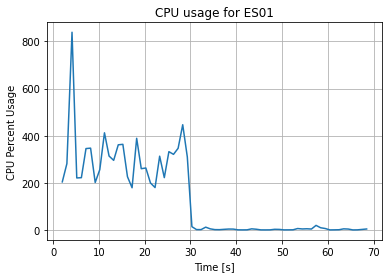

In [235]:
cpu_usage_plot(es01_stats_history, "ES01", False)

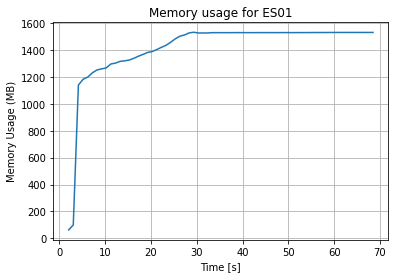

In [236]:
memory_usage_plot(es01_stats_history, "ES01")

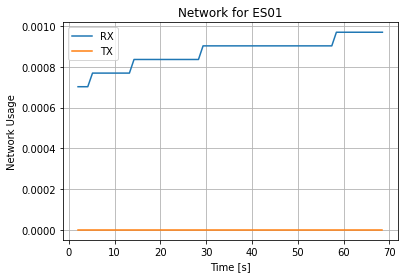

In [237]:
io_usage_plot(es01_stats_history, "ES01")

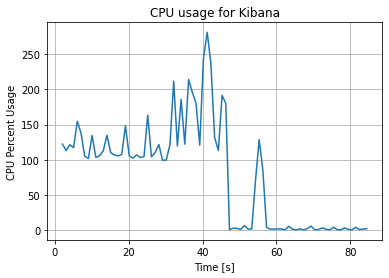

In [238]:
cpu_usage_plot(kibana_stats_history, "Kibana", False)

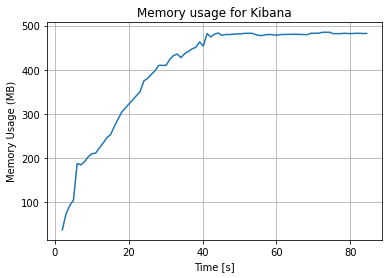

In [241]:
memory_usage_plot(kibana_stats_history, "Kibana")

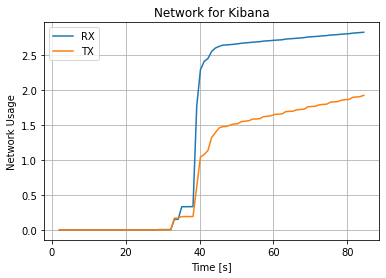

In [240]:
io_usage_plot(kibana_stats_history, "Kibana")

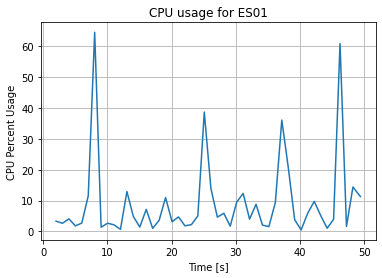

In [242]:
es = Elasticsearch("https://localhost:9200", basic_auth=("elastic", "Z0mbPEhMV*T0CqhXDHXv"))
es01_stats_history = profiler(es01_container)
es.ping()
es.info()
cpu_usage_plot(es01_stats_history, "ES01", False)

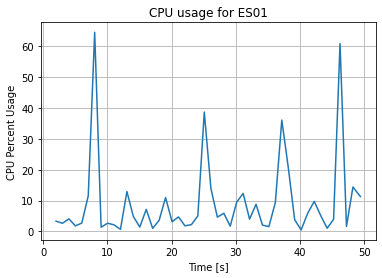

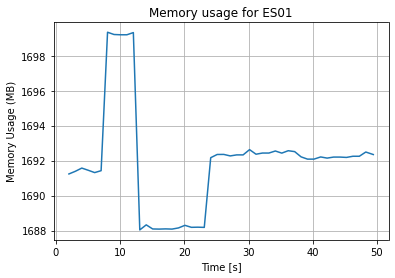

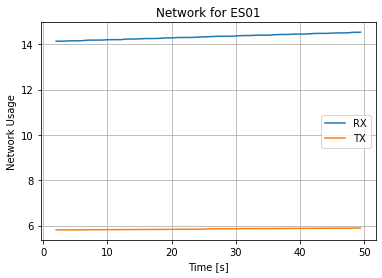

In [243]:
cpu_usage_plot(es01_stats_history, "ES01", False)
memory_usage_plot(es01_stats_history, "ES01")
io_usage_plot(es01_stats_history, "ES01")

C:\Users\gswr\AppData\Local\Temp\ipykernel_30236\2168799095.py:56: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  response = self.es.indices.create(


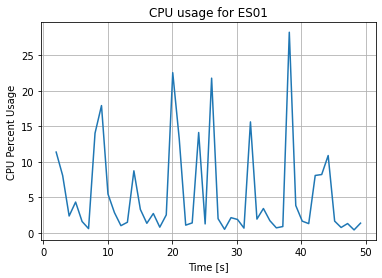

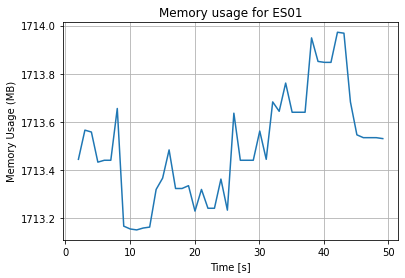

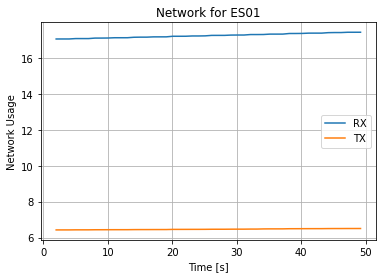

In [244]:
Benchmark = DatabaseBenchmark(es=es)
Benchmark.remove_index("vector-index")
Benchmark.create_index("vector-index")
es01_stats_history = profiler(es01_container)
cpu_usage_plot(es01_stats_history, "ES01", False)
memory_usage_plot(es01_stats_history, "ES01")
io_usage_plot(es01_stats_history, "ES01")

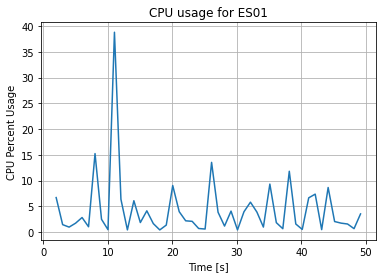

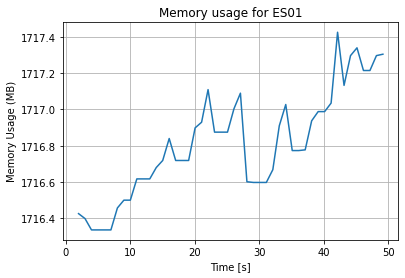

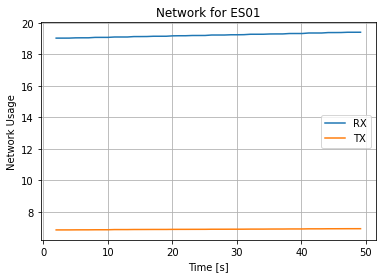

In [245]:
ibt = Benchmark.measure_index_building_time(data)
es01_stats_history = profiler(es01_container)
cpu_usage_plot(es01_stats_history, "ES01", False)
memory_usage_plot(es01_stats_history, "ES01")
io_usage_plot(es01_stats_history, "ES01")

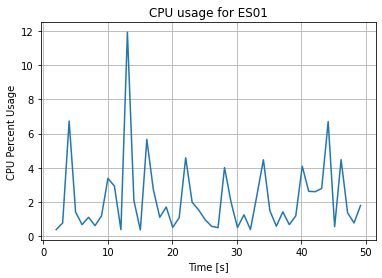

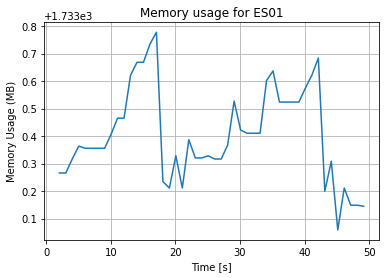

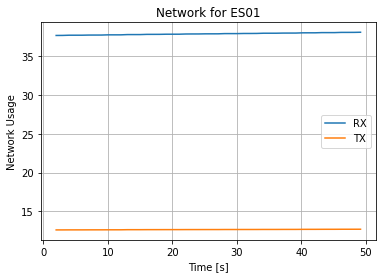

In [255]:
qps = Benchmark.measure_qps(temp_vector=data.embedding[0], num_queries = 1000)
es01_stats_history = profiler(es01_container)
cpu_usage_plot(es01_stats_history, "ES01", False)
memory_usage_plot(es01_stats_history, "ES01")
io_usage_plot(es01_stats_history, "ES01")

In [256]:
print("QPs", qps)

QPs 19.654911988241118


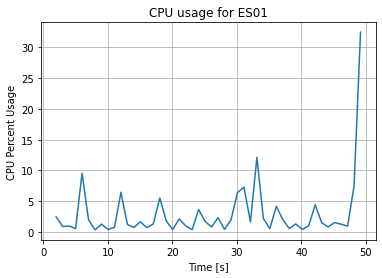

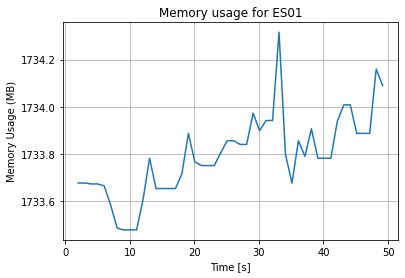

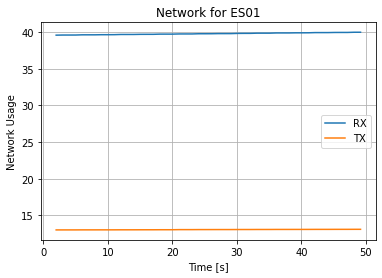

In [257]:
ql = Benchmark.measure_latency(temp_vector=data.embedding[0])
es01_stats_history = profiler(es01_container)
cpu_usage_plot(es01_stats_history, "ES01", False)
memory_usage_plot(es01_stats_history, "ES01")
io_usage_plot(es01_stats_history, "ES01")

In [258]:
print("QL", ql)

QL 0.05786159999843221


# Threads approach:

In [259]:
import docker
import time
from threading import Thread, Event
from queue import Queue
time_constant = 30

# A function that gets the docker stats and puts them in a queue
def get_docker_stats(queue_in, queue_out, event):
    print("Starting profile")
    client = docker.from_env()
    container = client.containers.get("b2b9850a61f8fe9ee18cc2f46016630253bdf0f359c918b31da3ab2f9a4ce416") # Change this to your container name or id
    temp_stats = []
    #while not event.is_set():
    cpu_max = 0
    container_history = [] # create an empty list to store the stats
    std_array = np.zeros([50])
    std_index = 0
    for stats in container.stats(stream=True, decode=True): # iterate over the stats generator
        container_history.append(stats)
        cpu_value = stats["cpu_stats"]["cpu_usage"]["total_usage"]
        std_array[std_index] = cpu_value
        std_index = std_index + 1
        if std_index>=50:
            std_index = 0
        #print(std_array.std())
        if cpu_value > cpu_max:
            cpu_max = cpu_value
        if std_array.std() < 0.1*cpu_max:
            break
    #return container_history
    print("Profile ended")
    queue_out.put(container_history)

        #mem_usage = stats["memory_stats"]["usage"]
        #mem_usage_mb = mem_usage / (1024**2)
        #cpu_usage = stats["cpu_stats"]["cpu_usage"]["total_usage"]
        #temp_stats.append(stats)
        #time.sleep(0.1) # Change this to your desired interval


# A function that does some other task and puts the result in a queue
def do_something_else(queue_in, queue_out, event):
    while not event.is_set():

        es = Elasticsearch("https://localhost:9200", basic_auth=("elastic", "Z0mbPEhMV*T0CqhXDHXv"))
        es01_stats_history = profiler(es01_container)
        es.ping()
        es.info()

        Benchmark = DatabaseBenchmark(es=es)
        Benchmark.remove_index("vector-index")
        Benchmark.create_index("vector-index")
        result = "Done"
        queue_out.put(result)
        time.sleep(time_constant)


def containers_initializer(queue_in, queue_out, event):
    #while not event.is_set():
    client = docker.from_env()

    kibana_container = client.containers.get("ed7d2147833d2dec5df5ccc76fef80a9ca26ef02a9b7e4c16191ab61e425169c")
    es01_container = client.containers.get("b2b9850a61f8fe9ee18cc2f46016630253bdf0f359c918b31da3ab2f9a4ce416")
    print("Starting ES01")
    es01_container.start()
    print("Starting Kibana")
    kibana_container.start()
    result = "Done"
    queue_out.put(result)
    time.sleep(time_constant)


def elastic_initializer(queue_in, queue_out, event):
    #while not event.is_set():
    print("Initializing Elastic")
    es = Elasticsearch("https://localhost:9200", basic_auth=("elastic", "Z0mbPEhMV*T0CqhXDHXv"))
    es.ping()
    es.info()
    result = "Done"
    queue_out.put(result)
    time.sleep(time_constant)

def elastic_reset_index(queue_in, queue_out, event):
    #while not event.is_set():
    print("Resetting index")
    Benchmark = DatabaseBenchmark(es=es)
    Benchmark.remove_index("vector-index")
    Benchmark.create_index("vector-index")
    result = "Done"
    print(result)
    queue_out.put(result)
    time.sleep(time_constant)

def elastic_build_index(queue_in, queue_out, event):
    #while not event.is_set():
    print("Building index")
    ibt = Benchmark.measure_index_building_time(data)
    queue_out.put(ibt)
    print("Done")
    time.sleep(time_constant)

def elastic_measure_qps(queue_in, queue_out, event):
    #while not event.is_set():
    print("Measuring QPS")
    qps = Benchmark.measure_qps(temp_vector=data.embedding[0], num_queries = 20)
    queue_out.put(qps)
    print("Done")
    time.sleep(time_constant)

def elastic_measure_latency(queue_in, queue_out, event):
    #while not event.is_set():
    print("Measuring latency")
    ql = Benchmark.measure_latency(temp_vector=data.embedding[0])
    queue_out.put(ql)
    print("Done")
    time.sleep(time_constant)


Containers initialization:

In [260]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=containers_initializer, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()


# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    function_results = queue1.get()
if not queue2.empty():
    containers_initializer_thread_stats = queue2.get()

Starting profile
Starting ES01
Starting Kibana
Profile ended


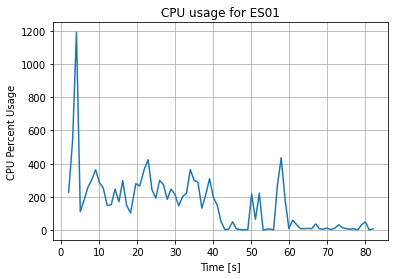

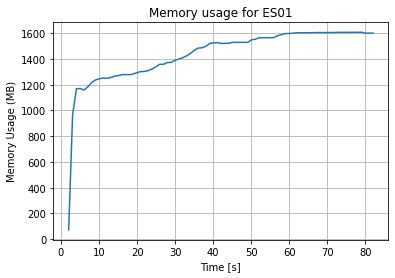

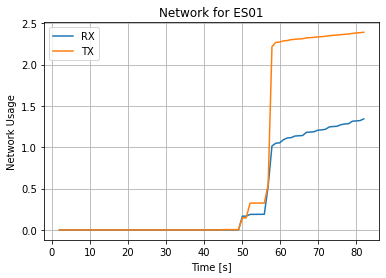

In [261]:
cpu_usage_plot(containers_initializer_thread_stats, caption="ES01")
memory_usage_plot(containers_initializer_thread_stats, caption="ES01")
io_usage_plot(containers_initializer_thread_stats, caption="ES01")

Elastic initialization

In [262]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=elastic_initializer, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()

# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    elastic_initializer_function_results = queue1.get()
if not queue2.empty():
    elastic_initializer_thread_stats = queue2.get()

Starting profile
Initializing Elastic
Profile ended


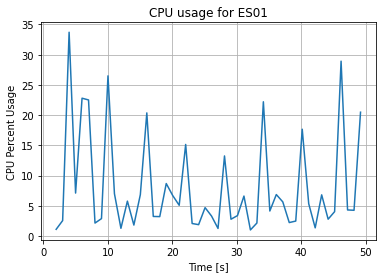

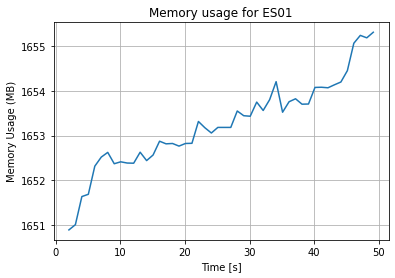

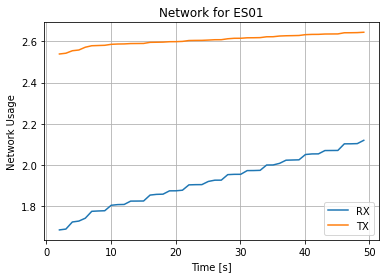

In [ ]:
cpu_usage_plot(elastic_initializer_thread_stats, caption="ES01")
memory_usage_plot(elastic_initializer_thread_stats, caption="ES01")
io_usage_plot(elastic_initializer_thread_stats, caption="ES01")

Elastic reset index

In [263]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=elastic_reset_index, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()

# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    elastic_reset_index_function_results = queue1.get()
if not queue2.empty():
    elastic_reset_index_thread_stats = queue2.get()

Starting profile
Resetting index


C:\Users\gswr\AppData\Local\Temp\ipykernel_30236\2168799095.py:56: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  response = self.es.indices.create(


Done
Profile ended


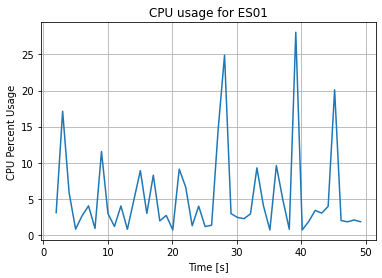

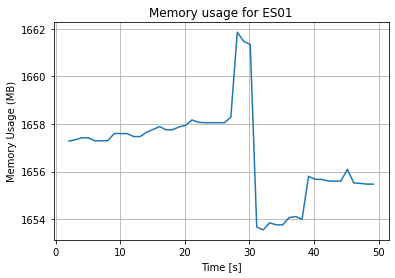

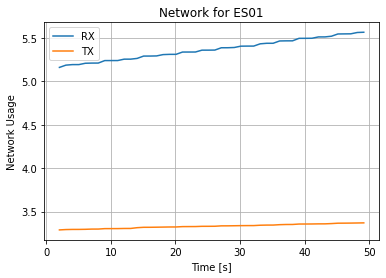

In [264]:
cpu_usage_plot(elastic_reset_index_thread_stats, caption="ES01")
memory_usage_plot(elastic_reset_index_thread_stats, caption="ES01")
io_usage_plot(elastic_reset_index_thread_stats, caption="ES01")

Elastic build index

In [265]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=elastic_build_index, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()

# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    elastic_build_index_function_results = queue1.get()
if not queue2.empty():
    elastic_build_index_thread_stats = queue2.get()

Starting profile
Building index
Done
Profile ended


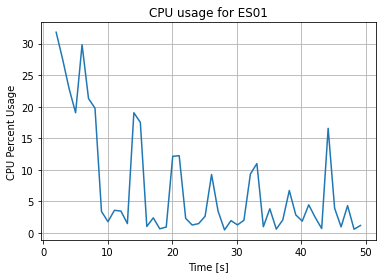

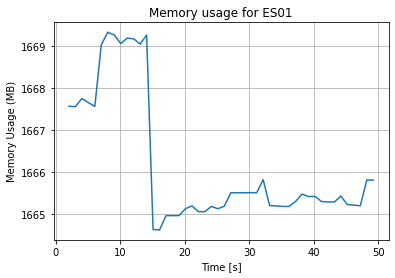

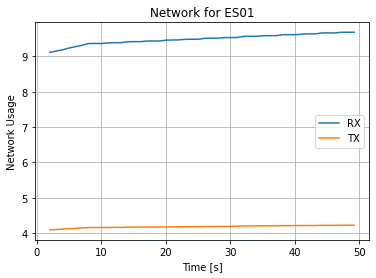

In [266]:
cpu_usage_plot(elastic_build_index_thread_stats, caption="ES01")
memory_usage_plot(elastic_build_index_thread_stats, caption="ES01")
io_usage_plot(elastic_build_index_thread_stats, caption="ES01")

Elastic measure QPS

In [270]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=elastic_measure_qps, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()

# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    elastic_measure_qps_function_results = queue1.get()
if not queue2.empty():
    elastic_measure_qps_thread_stats = queue2.get()

Starting profile
Measuring QPS
Done
Profile ended


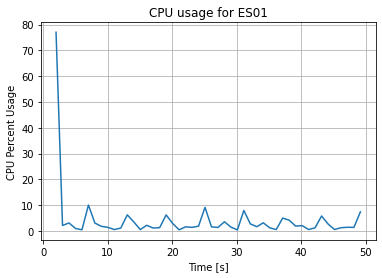

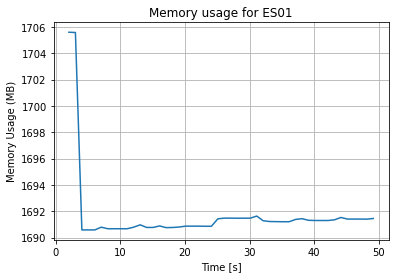

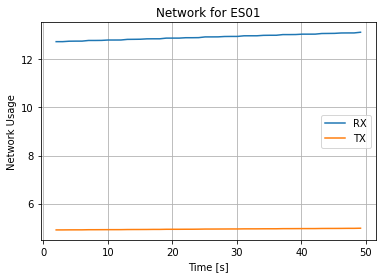

In [271]:
cpu_usage_plot(elastic_measure_qps_thread_stats, caption="ES01")
memory_usage_plot(elastic_measure_qps_thread_stats, caption="ES01")
io_usage_plot(elastic_measure_qps_thread_stats, caption="ES01")

Elastic measure latency

In [ ]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=elastic_measure_latency, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()

# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    elastic_measure_latency_function_results = queue1.get()
if not queue2.empty():
    elastic_measure_latency_thread_stats = queue2.get()

Starting profile
Measuring latency
Done
Profile ended


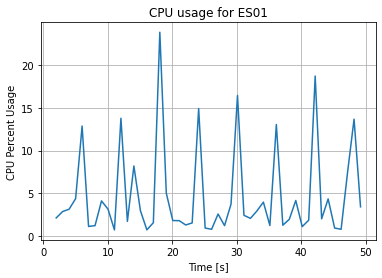

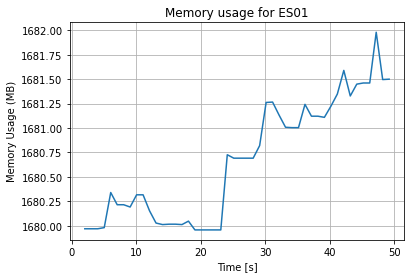

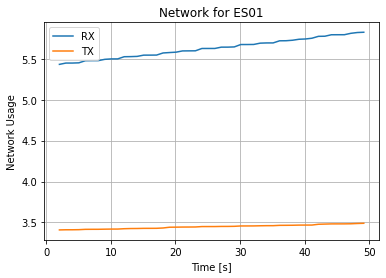

In [ ]:
cpu_usage_plot(elastic_measure_latency_thread_stats, caption="ES01")
memory_usage_plot(elastic_measure_latency_thread_stats, caption="ES01")
io_usage_plot(elastic_measure_latency_thread_stats, caption="ES01")

Rastros de una anterior versión:

In [ ]:
#print(f'Index Building Time: {ibt} Segundos \nQueries Per Second: {qps}\nQuery Latency: {ql} Segundos')

NameError: name 'ql' is not defined

In [ ]:
#query = es.search(
#            index="news_index",
#            body={
#            "size": 1,
#            "query": {
#                "match":{
#                    "AUTOR": "¿Quién es Quijote de la Mancha?"
#                }
#            }
#            }
#        )
#output = pd.json_normalize((query['hits']['hits']))

In [ ]:
#dataset = pd.read_csv("/textos.csv")
#print(f"shape of dataset: {dataset.shape}")
#dataset.head()

In [ ]:
#MY_INDEX = es.indices.create(index="news_index", ignore=[400,404], body=Settings)
#MY_INDEX

In [ ]:
#json_Formatted_dataset = json_formatter(dataset=dataset, index_name='news_index', index_type='_doc')
#json_Formatted_dataset[0]

In [ ]:
# For importing Data to elasticsearch we use elasticsearch's bulk API from elasticsearch.helpers
#try:
#    res = helpers.bulk(es, json_Formatted_dataset)
#    print("successfully imported to elasticsearch.")
#except Exception as e:
#    print(f"error: {e}")

# Vector search for Elastic



Otros enlaces importantes:
https://colab.research.google.com/github/HamidRezaAttar/Elasticsearch-Jupyter-Colab/blob/main/notebooks/python-elasticsearch-colab.ipynb#scrollTo=KgU86UyYNHLq

https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/elasticsearch.ipynb#scrollTo=XkXyocIdKRSB